In [1]:
#!python -m pip install chart_studio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sn
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller

In [3]:
from statsmodels.tsa.api import VAR
gdp_df=pd.read_csv('C:\\Users\\nafissaad\\Tutorial\\Time series\\Time Series Forecasting Derek Banas\\New folder\\gdp-data.csv',
                  index_col='date',parse_dates=True)

In [4]:
gdp_df#Biz_apps(Business application formed),prod(overall productivity of a cityzen)

,gdp,biz-apps,prod
date,,,
2004-09-30,12522.425,574777,89.09
2004-12-31,12761.337,583203,89.82
2005-03-31,12910.022,610664,89.53
2005-06-30,13142.873,618094,89.85
2005-09-30,13332.316,630382,90.22
...,...,...,...
2019-03-31,21329.877,867497,103.51
2019-06-30,21540.325,865909,103.55
2019-09-30,21747.394,859345,103.64


In [5]:
gdp_df = gdp_df[gdp_df.index<'2020-03-31']
gdp_df= gdp_df.dropna()
gdp_df= gdp_df.asfreq('Q')
len(gdp_df)

62

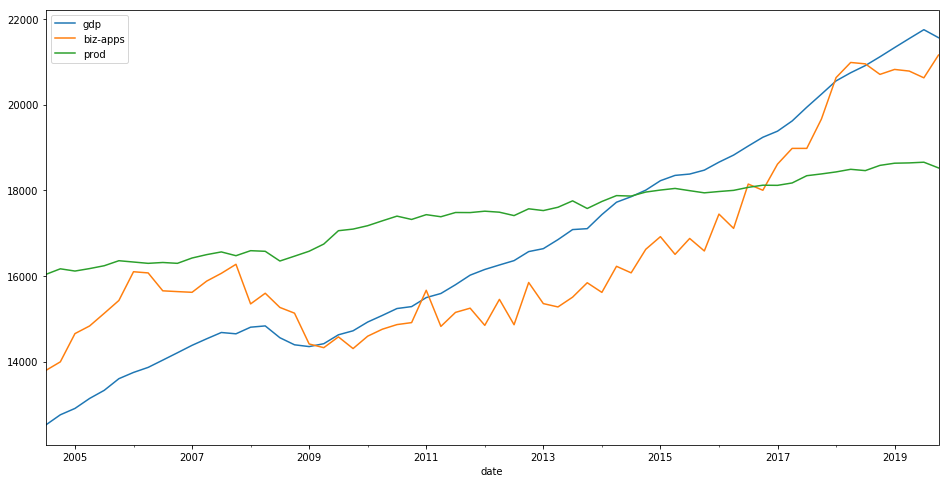

In [6]:
gdp_df['gdp'].plot(legend=True,figsize=(16,8))
gdp_df['biz-apps']=gdp_df['biz-apps']*0.024#21561.139/881487=0.02445996254057065
gdp_df['biz-apps'].plot(legend=True)
gdp_df['prod']=gdp_df['prod']*180#21561.139/102.90=209.5348785228377
gdp_df['prod'].plot(legend=True)
#Scaling other variable with gdp

,gdp,biz-apps,prod
date,,,
2004-12-31,238.912,202.224,131.4
2005-03-31,148.685,659.064,-52.2
2005-06-30,232.851,178.320,57.6
2005-09-30,189.443,294.912,66.6
2005-12-31,271.617,299.736,117.0
...,...,...,...
2018-12-31,205.456,-246.048,122.4
2019-03-31,214.568,115.752,50.4
2019-06-30,210.448,-38.112,7.2


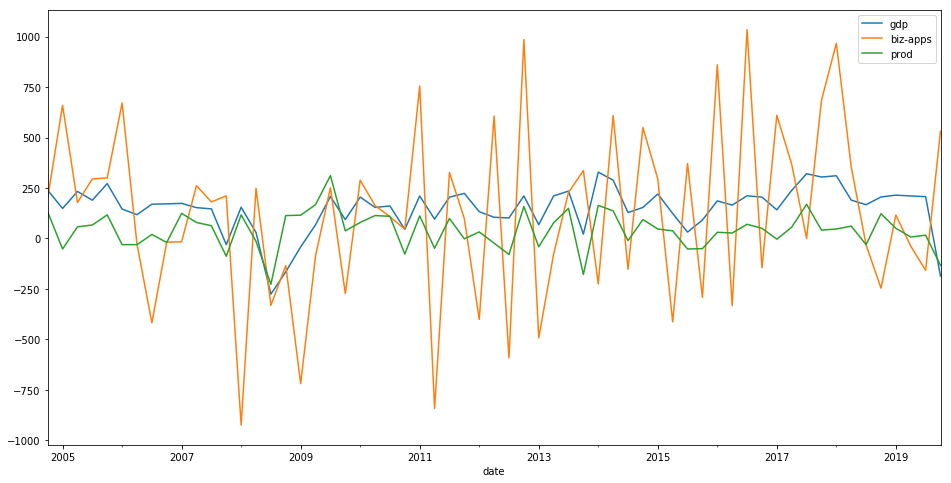

In [7]:
#Make our Data stationary 
gdp_diff_df = gdp_df.diff()
gdp_diff_df=gdp_diff_df.dropna()
gdp_diff_df.plot(legend=True,figsize=(16,8))
gdp_diff_df

In [8]:
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

In [9]:
adf_test(gdp_diff_df['gdp'])
adf_test(gdp_diff_df['biz-apps'])
adf_test(gdp_diff_df['prod'])#p_value less than 0.05 means the data is stationary

Dickey-Fuller Test
Test Statistic                 -4.231840
p-value                         0.000582
#Lags Used                      0.000000
Number of Observations Used    60.000000
dtype: float64
Dickey-Fuller Test
Test Statistic                 -4.847785
p-value                         0.000044
#Lags Used                      1.000000
Number of Observations Used    59.000000
dtype: float64
Dickey-Fuller Test
Test Statistic                -8.342130e+00
p-value                        3.155371e-13
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
dtype: float64


In [10]:
len(gdp_diff_df)

61

In [11]:
#train and test data 
train_df= gdp_diff_df[:-10]#183*80%=146
test_df = gdp_diff_df[-10:]
mod=VAR(train_df)
for p in range(1,8):#P is number of lag taking in our model we are taking past 1St quarter data
    res=mod.fit(p)
    print(f'Order:{p}, AIC:{res.aic}')

Order:1, AIC:29.09897934335431
Order:2, AIC:29.286391651694395
Order:3, AIC:29.304269340946195
Order:4, AIC:29.273298278057506
Order:5, AIC:29.08873032624295
Order:6, AIC:29.118233324366436
Order:7, AIC:29.325471458583237


In [12]:
res=mod.fit(5)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Jul, 2022
Time:                     22:33:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    30.9969
Nobs:                     46.0000    HQIC:                   29.8035
Log likelihood:          -816.854    FPE:                4.70471e+12
AIC:                      29.0887    Det(Omega_mle):     1.92146e+12
--------------------------------------------------------------------
Results for equation gdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             129.114489        46.934812            2.751           0.006
L1.gdp              1.225092         0.301681            4.061           0.000
L1.biz-apps        -0.015705         0.046479           -0.338        

In [13]:
Forecas_res=res.forecast(train_df.values[-5:],10)#gdp_diff_df.values means converting it into numpy array,we are pass in 4 values,which is quarterly data. so, it would be like a year
#res.plot_forecast(2);
gdp_diff_df.values[-5:]

array([[ 205.456, -246.048,  122.4  ],
       [ 214.568,  115.752,   50.4  ],
       [ 210.448,  -38.112,    7.2  ],
       [ 207.069, -157.536,   16.2  ],
       [-186.255,  531.408, -133.2  ]])

In [14]:
index=pd.date_range('2017-09-30',periods=10,freq="Q-DEC")
forecast_df = pd.DataFrame(Forecas_res, index=index,
                          columns=['gdp','biz-apps', 'prod'])
forecast_df['gdp']

2017-09-30    174.979982
2017-12-31    220.061172
2018-03-31    187.237200
2018-06-30    184.629139
2018-09-30    159.675745
2018-12-31    164.326682
2019-03-31    155.112267
2019-06-30    139.328895
2019-09-30    152.754793
2019-12-31    148.766487
Freq: Q-DEC, Name: gdp, dtype: float64

In [15]:
#Undoing a difference
ex_df = pd.DataFrame({'A': np.random.randint(0, 10, 5)})
ex_df['B'] = ex_df['A'].diff()
ex_df#made it stationary

,A,B
0,8,NaN
1,7,-1.0
2,7,0.0
3,1,-6.0
4,9,8.0


In [16]:
ex_df['A'].iloc[0],ex_df['B'].iloc[1:]

(8,
 1   -1.0
 2    0.0
 3   -6.0
 4    8.0
 Name: B, dtype: float64)

In [17]:
x,x_diff=ex_df['A'].iloc[0],ex_df['B'].iloc[1:]

In [18]:
ex_df['C'] = np.r_[x, x_diff].cumsum().astype(float)
ex_df

,A,B,C
0,8,NaN,8.0
1,7,-1.0,7.0
2,7,0.0,7.0
3,1,-6.0,1.0
4,9,8.0,9.0


In [19]:
dt=train_df['gdp']
dm=forecast_df['gdp']
t=dt.append(dm)
len(t)

61

In [20]:

# Generate random data and difference it
ex_df = pd.DataFrame({'A': np.random.randint(0, 10, 5)})
ex_df['B'] = ex_df['A'].diff()
ex_df

x, x_diff = ex_df['A'].iloc[0], ex_df['B'][1:]
# r_ stack slices along their 1st axis
ex_df['C'] = np.r_[x, x_diff].cumsum().astype(float)
ex_df

# Get all of original GDP column and the differenced column skipping
# the NaNs at the front
x, x_diff = gdp_df['gdp'].iloc[0], t
# Cumulatively sum the values and stack the slices to eliminate
# the difference
n_gdp_df = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))
#n_gdp_df.plot(figsize=(16,8))

# You can do the same with biz-apps and prod for homework
n_gdp_df

,0
0,12522.425000
1,12761.337000
2,12910.022000
3,13142.873000
4,13332.316000
...,...
57,20708.197920
58,20863.310187
59,21002.639082
60,21155.393875


In [21]:
rng = pd.date_range(start="2004-09-30",end="2019-12-31",freq='Q-DEC')
len(rng)

62

In [22]:
n_gdp_df.set_index(rng, inplace=True)

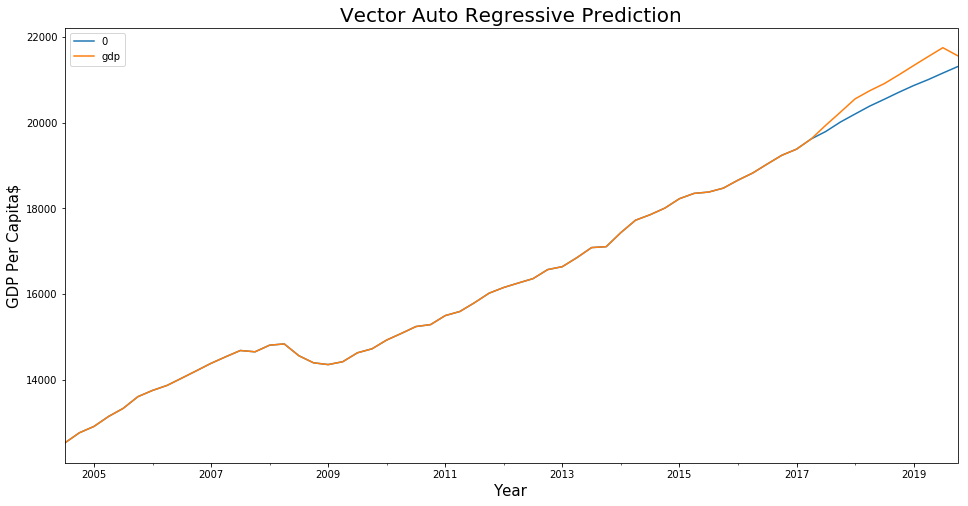

In [23]:
n_gdp_df.plot(legend=(4,4),figsize=(16,8))
gdp_df['gdp'].plot(legend=(4,4),figsize=(16,8))
plt.ylabel("GDP Per Capita$",fontsize=15)
plt.xlabel("Year",fontsize=15)
plt.title('Vector Auto Regressive Prediction',fontsize=20)
plt.show()